In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
import numpy as np
#!pip install scikit-image
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import nltk
from nltk.util import ngrams
from spacy.lang.en import English
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
nlp = English()

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

In [ ]:
!pip install -q xlrd
!git clone https://github.com/ana-bca/Proyecto-Mineria-de-Datos

Cloning into 'Proyecto-Mineria-de-Datos'...
remote: Enumerating objects: 4424, done.
remote: Counting objects: 100% (4424/4424), done.
remote: Compressing objects: 100% (4424/4424), done.
remote: Total 78189 (delta 0), reused 4420 (delta 0), pack-reused 73765
Receiving objects: 100% (78189/78189), 2.18 GiB | 37.60 MiB/s, done.
Resolving deltas: 100% (966/966), done.


In [ ]:
# Lectura de tablas ==========================================================#
#data_F = pd.read_csv('Proyecto-Mineria-de-Datos/data_F.csv', engine='python',sep=",")
data_train = pd.read_csv('Proyecto-Mineria-de-Datos/Imagenes/data_train.csv', engine='python',sep="\t")
data_test = pd.read_csv('Proyecto-Mineria-de-Datos/Imagenes/data_test.csv', engine='python',sep="\t")
data_valid = pd.read_csv('Proyecto-Mineria-de-Datos/Imagenes/data_valid.csv', engine='python',sep="\t")

Ngrams_1 = pd.read_csv('Proyecto-Mineria-de-Datos/palabras_finales.csv', engine='python',sep="\t")
# Funciones ==================================================================#
def TUPT(x):
    x_N1 = np.array(NGRAM(x,1))
    x_N1 = x_N1.reshape(x_N1.shape[0],)
    x_T = list(set(x_N1.astype(str)))
    return x_T
def NGRAM(x,n):
    token=nltk.word_tokenize(str(x))
    bigrams=ngrams(token,n)
    return list(bigrams)

In [ ]:
data_train.head(5)

,photo_id,caption
0,wepv7u5SL70ddvufCFpehA.jpg,burger
1,zFjkL0f_1jDL5b3YRXLq-A.jpg,steak egg
2,yPbL_mGc6C22Ed8H0NLa-A.jpg,salad
3,GeNWGjy4HC7gatYq0R7kYA.jpg,beef
4,XYoozoyDA2MpUSnhmi1-vQ.jpg,steak egg


In [ ]:
# Generamos las clases en los dataframe
import nltk
nltk.download('punkt')
data_train = data_train.assign(tags = np.array(data_train.caption.map(lambda p: TUPT(p))))
data_test = data_test.assign(tags = np.array(data_test.caption.map(lambda p: TUPT(p))))
data_valid = data_valid.assign(tags = np.array(data_valid.caption.map(lambda p: TUPT(p))))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data_train.head()

,photo_id,caption,tags
0,wepv7u5SL70ddvufCFpehA.jpg,burger,[burger]
1,zFjkL0f_1jDL5b3YRXLq-A.jpg,steak egg,"[steak, egg]"
2,yPbL_mGc6C22Ed8H0NLa-A.jpg,salad,[salad]
3,GeNWGjy4HC7gatYq0R7kYA.jpg,beef,[beef]
4,XYoozoyDA2MpUSnhmi1-vQ.jpg,steak egg,"[steak, egg]"


In [ ]:
# Cree un ImageDataGenerator con flow_from_dataframe
## Clases en los datos
Ngrams_1 = Ngrams_1.word.values
keys = list(set(Ngrams_1.astype(str)))
len(keys)

20

In [ ]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen_train.flow_from_dataframe(
    dataframe = data_train[["photo_id","tags"]],
    directory = "Proyecto-Mineria-de-Datos/Imagenes/train",
    x_col = "photo_id",
    y_col = "tags",
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True,
    color_mode = "rgb",
    classes = keys,
    target_size = (200,250))

valid_generator = datagen.flow_from_dataframe(
    dataframe = data_valid[["photo_id","tags"]],
    directory = "Proyecto-Mineria-de-Datos/Imagenes/valid",
    x_col = "photo_id",
    y_col = "tags",
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True,
    color_mode = "rgb",
    classes = keys,
    target_size = (200,250))

test_generator = datagen.flow_from_dataframe(
    dataframe = data_test[["photo_id","tags"]],
    directory = "Proyecto-Mineria-de-Datos/Imagenes/test",
    x_col = "photo_id",
    y_col = "tags",
    batch_size = 32,
    class_mode = None,
    shuffle=True,
    color_mode = "rgb",
    target_size = (200,250))

Found 2591 validated image filenames belonging to 20 classes.
Found 876 validated image filenames belonging to 20 classes.
Found 1000 validated image filenames.


In [ ]:
# Construye el modelo:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

EPOCHS = 30
INIT_LR = 1e-3
BS = 32

model = Sequential()
inputShape = (200,250,3)
chanDim = -1
if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(len(keys)))
model.add(Activation("sigmoid"))
#------------------------------------------------------------_#
# initialize the optimizer (SGD is sufficient)
from keras.optimizers import Adam
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
80/80 [==============================] - 441s 6s/step - loss: 0.7425 - accuracy: 0.5798 - val_loss: 0.5222 - val_accuracy: 0.7554
Epoch 2/30
80/80 [==============================] - 435s 5s/step - loss: 0.5446 - accuracy: 0.7534 - val_loss: 0.3832 - val_accuracy: 0.8937
Epoch 3/30
80/80 [==============================] - 434s 5s/step - loss: 0.3545 - accuracy: 0.8845 - val_loss: 0.2259 - val_accuracy: 0.9381
Epoch 4/30
80/80 [==============================] - 442s 6s/step - loss: 0.2810 - accuracy: 0.9213 - val_loss: 0.2185 - val_accuracy: 0.9389
Epoch 5/30
80/80 [==============================] - 437s 5s/step - loss: 0.2558 - accuracy: 0.9307 - val_loss: 0.2598 - val_accuracy: 0.9376
Epoch 6/30
80/80 [==============================] - 437s 5s/step - loss: 0.2457 - accuracy: 0.9344 - val_loss: 0.2681 - val_accuracy: 0.9391
Epoch 7/30
80/80 [==============================] - 438s 5s/step - loss: 0.2411 - accuracy: 0.9346 - val_loss: 0.2240 - val_accuracy: 0.9384
Epoch 8/30
80

In [ ]:
# Guardamos el modelo final 
#model.save('my_model.h6')
# Cargamos el modelo final
model = keras.models.load_model('my_model.h6')

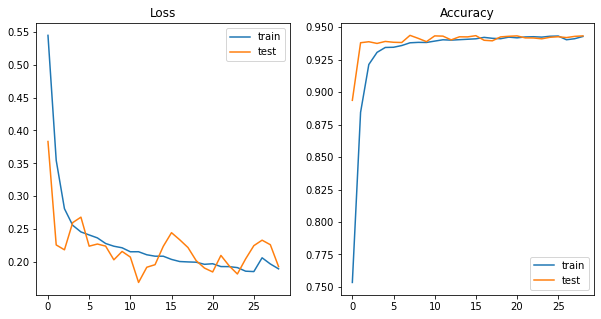

In [ ]:
# Graficas de validaciones ====================================================#
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,5
fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'][1:], label='train')
axs[0].plot(history.history['val_loss'][1:], label='test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'][1:], label='train')
axs[1].plot(history.history['val_accuracy'][1:], label='test')
axs[1].set_title('Accuracy')
axs[1].legend()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000036,0.000044,0.004421,0.004950,0.006300,0.008813,0.009810,0.017366,0.019233,0.021592,0.028423,0.029423,0.036720,0.059355,0.071663,0.071715,0.072469,0.072832,0.082619,0.086235
1,0.002055,0.002125,0.027610,0.035728,0.040162,0.048352,0.059739,0.061092,0.064902,0.066984,0.075156,0.077231,0.089152,0.093265,0.100206,0.101351,0.116541,0.147165,0.153278,0.202873
2,0.000959,0.001374,0.034560,0.035332,0.036893,0.038943,0.048148,0.049285,0.054859,0.057625,0.059300,0.060501,0.067586,0.084315,0.090384,0.098185,0.106758,0.107208,0.109834,0.166254
3,0.000091,0.000228,0.008184,0.010112,0.010244,0.013165,0.014069,0.017063,0.022992,0.026129,0.026303,0.027516,0.049210,0.070889,0.078561,0.089563,0.091926,0.098112,0.103270,0.400402
4,0.000058,0.000284,0.010644,0.010673,0.011652,0.012267,0.015895,0.019288,0.027849,0.029112,0.041676,0.041990,0.048549,0.056987,0.061483,0.069585,0.079281,0.080958,0.089221,0.096597


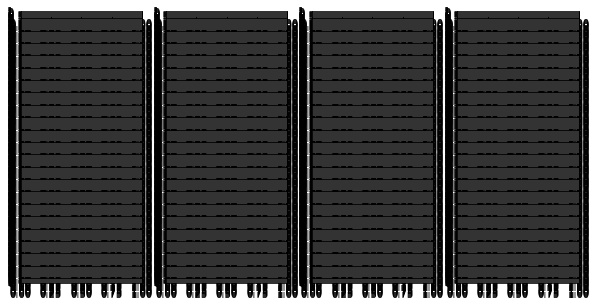

In [ ]:
import os
import keras
test_dir = 'Proyecto-Mineria-de-Datos/Imagenes/test'
classes = train_generator.class_indices
decode_classes = {v: k for k, v in classes.items()}
decode_classes
filenames_full = []
for dirpath, dirnames, filenames in os.walk(test_dir):
    for filename in filenames:
        filenames_full.append(os.path.join(dirpath, filename))
filenames_full = filenames_full
rows = (len(filenames_full) - 1) // 4 + 1
Table_pred = []
names_photos = []
for index, filename_full in enumerate(filenames_full):
    plt.subplot(rows, 4, index + 1)
    names_photos.append(filenames_full)
    test_image = keras.preprocessing.image.load_img(filename_full, target_size=(200,250))
    test_input = keras.preprocessing.image.img_to_array(test_image) * (1. / 255)
    test_input = np.expand_dims(test_input, axis=0)
    prediction = model.predict(test_input)
    Table_pred.append(list(np.sort(prediction)[::-1]))
Table_pred = pd.DataFrame(np.vstack(Table_pred))
Table_pred.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
cluster.fit_predict(Table_pred.iloc[:,17:])
unique_elements, counts_elements = np.unique(cluster.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  0   1   2]
 [102 218 680]]


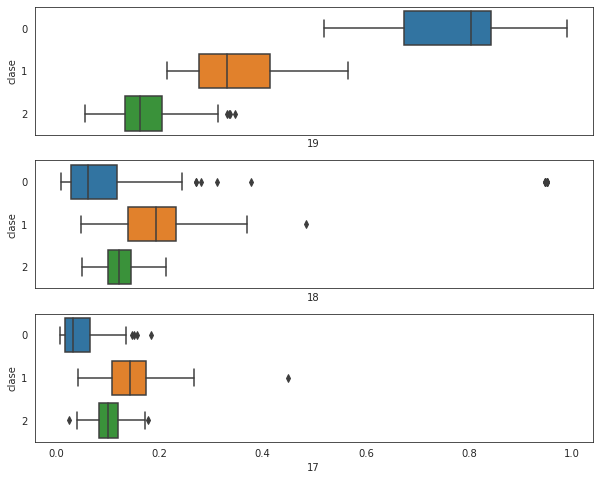

In [ ]:
# Graficas para primera etiqueta
import seaborn as sns
sns.set_style("white")
Table_plot = Table_pred.iloc[:,17:].assign(clase = cluster.labels_)
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8),sharex=True)
sns.boxplot(x = Table_plot.iloc[:,2],y = Table_plot.clase,orient="h",ax=ax1)
sns.boxplot(x = Table_plot.iloc[:,1],y = Table_plot.clase,orient="h",ax=ax2)
sns.boxplot(x = Table_plot.iloc[:,0],y = Table_plot.clase,orient="h",ax=ax3)

In [ ]:
Tab_Clus = pd.DataFrame({'name':filenames_full,'clase':cluster.labels_})
Tab_Clus.clase[Tab_Clus.clase == 2] = 3
Tab_Clus.clase[Tab_Clus.clase == 1] = 2
Tab_Clus.clase[Tab_Clus.clase == 0] = 1
Tab_Clus.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

,name,clase
0,Proyecto-Mineria-de-Datos/Imagenes/test/8GjmOT...,3
1,Proyecto-Mineria-de-Datos/Imagenes/test/eu0frK...,3
2,Proyecto-Mineria-de-Datos/Imagenes/test/qrX91d...,3
3,Proyecto-Mineria-de-Datos/Imagenes/test/jEu65a...,2
4,Proyecto-Mineria-de-Datos/Imagenes/test/N0ho8X...,3
5,Proyecto-Mineria-de-Datos/Imagenes/test/-4DVnZ...,3
6,Proyecto-Mineria-de-Datos/Imagenes/test/Y8kNha...,3
7,Proyecto-Mineria-de-Datos/Imagenes/test/ZT3vHQ...,3
8,Proyecto-Mineria-de-Datos/Imagenes/test/wzgCMN...,3
9,Proyecto-Mineria-de-Datos/Imagenes/test/fwdZ9S...,3


[0.09659672 0.08922103 0.08095771]
[0.3866485  0.23775354]
[0.11836022 0.1079587  0.07916674]
[0.629811]
[0.15879788 0.12826352 0.11991757]
[0.18483537 0.17704484 0.07882747]
[0.14154148 0.1385952  0.12451687]
[0.94940567]
[0.09953168 0.05924937 0.05158651]
[0.16437879 0.12237427 0.11496835]


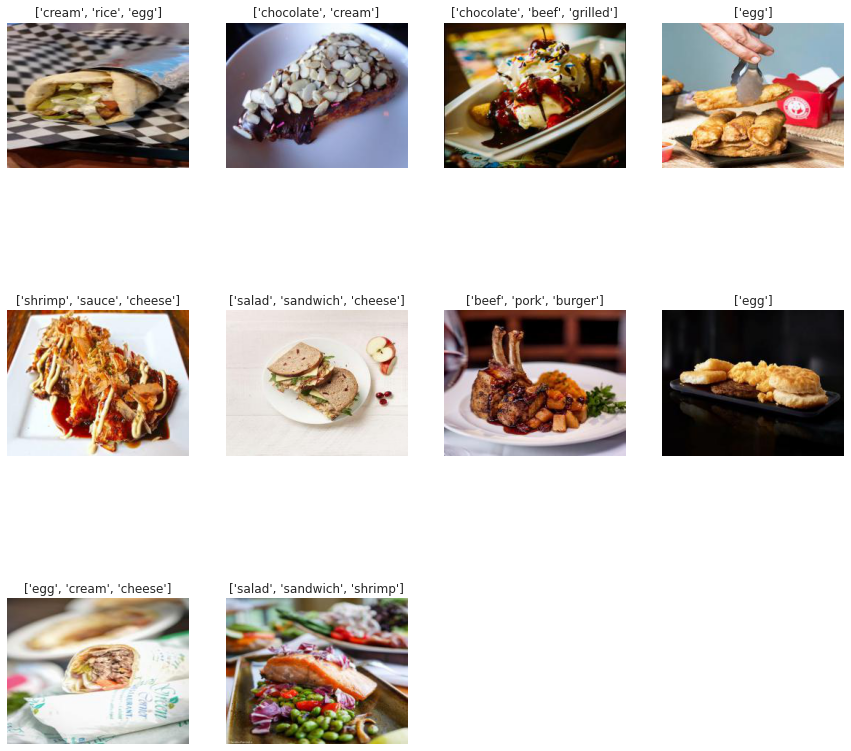

In [ ]:
from random import sample
filenames_sample = sample(filenames_full,10)
rows = (len(filenames_sample) - 1) // 4 + 1
plt.figure(figsize=(15, 5 * rows))
for index, filename_samp in enumerate(filenames_sample):
    plt.subplot(rows, 4, index + 1)
    test_image = keras.preprocessing.image.load_img(filename_samp, target_size=(200,250))
    test_input = keras.preprocessing.image.img_to_array(test_image) * (1. / 255)
    test_input = np.expand_dims(test_input, axis=0)
    plt.imshow(test_image)
    plt.axis('off')
    prediction = model.predict(test_input)
    prediction = prediction.reshape(len(keys),)
    etiq = []
    n_etiq = int(Tab_Clus[Tab_Clus.name == filename_samp].clase)
    pred_aux = prediction.copy()
    type_name = []
    for jj in range(n_etiq):
      etiq.append(np.argmax(pred_aux))
      type_name.append(decode_classes[np.argmax(pred_aux)])
      pred_aux[np.argmax(pred_aux)] = 0
    print(prediction[etiq])
    plt.title(type_name)